# Sequential High Dimensional Memory 

Setting up the environment:

In [15]:
import numpy as np
from sklearn.datasets import fetch_lfw_people
import tensorflow as tf
import pickle

# Encoding and Decoding the Autoencoder 
def encode(layer_sizes, data, encoders, biases):
    pl = data
    encoder_weights = encoders

    for i, ls in enumerate(layer_sizes[1:]):
        w = weights[i,:,:]
        b = biases[i,:]
        pl = tf.sigmoid(tf.matmul(pl, w) + b)

    return pl

def decode(layer_sizes, data, encoders, biases):
    pl = data
    encoder_weights = encoders

    for w, b, ls in zip(reversed(encoder_weights), reversed(biases), reversed(layer_sizes[:-1])):

        # return np.array([0])
        b = tf.zeros([ls])
        pl = tf.sigmoid(tf.matmul(pl, tf.transpose(w)) + b)

    return pl

## Cues and Inputs

Building up the cues and inputs to contain positional information for binding:

In [7]:
import matplotlib.pyplot as plt

import nengo
from nengo import spa

def color_input(t):
    if t < 0.25:
        return 'RED'
    elif t < 0.5:
        return 'BLUE'
    elif t < 0.75:
        return 'GREEN'
    else:
        return '0'

def position_input(t):
    if t < 0.25:
        return 'POS1'
    elif t < 0.5:
        return 'POS2'
    elif t < 0.75:
        return 'POS3'
    else:
        return '0'

def cue_input(t):
    if t < 0.75:
        return '0'
    sequence = ['0', 'POS1', 'RED', '0', 'POS2', 'BLUE', '0', 'POS3', 'GREEN']
    idx = int(((t - 0.75) // (1. / len(sequence))) % len(sequence))
    return sequence[idx]

## Model Construction

Next, we will build our model and simulate it:

In [12]:
# Number of dimensions for the Semantic Pointers
dimensions = 48
neurons = 40
model = spa.SPA(label="ImageRec")

with model:
    model.color_in = spa.Buffer(dimensions=dimensions)
    model.position_in = spa.Buffer(dimensions=dimensions)
    model.conv = spa.Memory(dimensions=dimensions, subdimensions=4, 
                            synapse=0.4, neurons_per_dimension=neurons)
    model.cue = spa.Buffer(dimensions=dimensions)
    model.out = spa.Buffer(dimensions=dimensions)

    # Connect the buffers
    cortical_actions = spa.Actions(
        'conv = color_in * position_in',
        'out = conv * ~cue'
    )
    model.cortical = spa.Cortical(cortical_actions)

    model.inp = spa.Input(color_in=color_input, position_in=position_input, cue=cue_input)

    model.config[nengo.Probe].synapse = nengo.Lowpass(0.03)
    color_in = nengo.Probe(model.color_in.state.output)
    position_in = nengo.Probe(model.position_in.state.output)
    cue = nengo.Probe(model.cue.state.output)
    conv = nengo.Probe(model.conv.state.output)
    out = nengo.Probe(model.out.state.output)

    sim = nengo.Simulator(model)
    sim.run(3.)

Building finished in 0:00:07.                                                   
Simulating finished in 0:01:31.                                                 


## Visualization

Visualize the results:

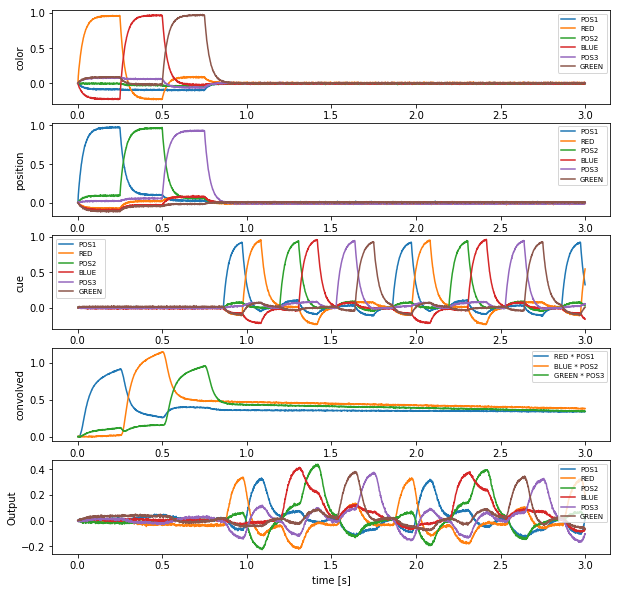

In [13]:
    plt.figure(figsize=(10, 10))
    vocab = model.get_default_vocab(dimensions)

    plt.subplot(5, 1, 1)
    plt.plot(sim.trange(), model.similarity(sim.data, color_in))
    plt.legend(model.get_output_vocab('color_in').keys, fontsize='x-small')
    plt.ylabel("color")

    plt.subplot(5, 1, 2)
    plt.plot(sim.trange(), model.similarity(sim.data, position_in))
    plt.legend(model.get_output_vocab('position_in').keys, fontsize='x-small')
    plt.ylabel("position")

    plt.subplot(5, 1, 3)
    plt.plot(sim.trange(), model.similarity(sim.data, cue))
    plt.legend(model.get_output_vocab('cue').keys, fontsize='x-small')
    plt.ylabel("cue")

    plt.subplot(5, 1, 4)
    for pointer in ['RED * POS1', 'BLUE * POS2', 'GREEN * POS3' ]:
        plt.plot(sim.trange(), vocab.parse(pointer).dot(sim.data[conv].T), label=pointer)
    plt.legend(fontsize='x-small')
    plt.ylabel("convolved")

    plt.subplot(5, 1, 5)
    plt.plot(sim.trange(), spa.similarity(sim.data[out], vocab))
    plt.legend(model.get_output_vocab('out').keys, fontsize='x-small')
    plt.ylabel("Output")
    plt.xlabel("time [s]");
    plt.show()

In [14]:
    print sim.data[out].shape
    print model.get_output_vocab('position_in').keys
    print model.get_output_vocab('color_in').keys
#     print spa.similarity(sim.data[out], vocab)

(3000, 48)
['POS1', 'RED', 'POS2', 'BLUE', 'POS3', 'GREEN']
['POS1', 'RED', 'POS2', 'BLUE', 'POS3', 'GREEN']
